Ensemble Kalman Filter <br>
リミットサイクルを発生する Van der Pol モデル

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
M = 100  # アンサンブル数
N = 500  # ステップ数
nx = 3
ny = 1
q1 = 0.1
q2 = 0.1
R = np.matrix([0.3])
Q = np.matrix([0.026,0.01,1e-5])
dt = 0.1
eps = 1.0
H = np.matrix([0,1,0])

time = np.arange(0,dt*N,dt)

def f(x):
    xx1 = x[0] + dt*x[1] + np.sqrt(dt)*np.random.normal(0,q1)
    xx2 = x[1] + dt*(x[2]*(1-x[0]**2)*x[1]-x[0]) + np.sqrt(dt)*np.random.normal(0,q2)
    return np.array([xx1,xx2,x[2]])

def obs(x):
    return H.dot(x) + np.random.normal(0,R)

x = np.zeros([N,nx])  # 状態ベクトル
y = np.zeros([N,ny])  # 観測ベクトル

In [20]:
x[0,:] = np.array([0.2,0.1,eps])

for i in range(1,N):
    x[i,:] = f(x[i-1,:])
    y[i,:] = obs(x[i,:])

In [21]:
# カルマンフィルター
Xp = np.zeros([N,M,nx])  # 一期先予測アンサンブル
Yp = np.zeros([N,M,ny])  # 一期先観測予測アンサンブル
Xpe = np.zeros([N,M,nx])  # 予測誤差アンサンブル
Ppe = np.zeros([N,M,nx,nx]) # 予測誤差共分散行列アンサンブル
Ype = np.zeros([N,M,ny])  # 一期先観測予測誤差アンサンブル
V = np.zeros([N,ny,ny])
U = np.zeros([N,nx,ny])
# 初期推定値
for m in range(M):
    Xp[0,m,:] = np.array([0,0,0])+np.random.normal(0,0.5,nx)

Xu = np.copy(Xp)  # フィルタ予測アンサンブル
xu = np.zeros([N,nx])

for i in range(1,N):
    # 予測更新ステップ
    for m in range(M):
        Xp[i,m,:] = f(Xu[i-1,m,:]) + np.random.normal(0,Q) # (7.22)
        
    # 観測更新ステップ
    xmean = np.mean(Xp[i,:,:], axis=0) # (7.7)
    for m in range(M):
        xr = Xp[i,m,:] - xmean # 一段階予測誤差
        Xpe[i,m,:] = xr # (7.8)
#         Ppe[i,m,:,:] = np.matmul(np.matrix(xr).T,np.matrix(xr))/(M-1) # (7.9)
        Yp[i,m,:] = obs(Xp[i,m,:]) + np.random.normal(0,R) # (7.10)
    ypmean = np.mean(Yp[i,:,:], axis=0)/M # (7.11)
    for m in range(M):
        Ype[i,m,:] = Yp[i,m,:]-ypmean # (7.12),(7.13)
    V[i,:,:] = Ype[i,:,:].T.dot(Ype[i,:,:])/(M-1) #(7.14)
    U[i,:,:] = Xpe[i,:,:].T.dot(Ype[i,:,:,])/(M-1) #(7.15)
    K = U[i,:,:].dot(np.linalg.inv(V[i,:,:])) # (7.16)カルマンゲイン
    for m in range(M):
        Xu[i,m,:] = Xp[i,m,:]+(K*(y[i,:]-Yp[i,m,:])).squeeze()
    xu[i] = np.mean(Xu[i,:,:], axis=0)

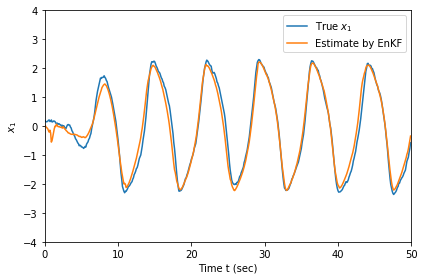

In [48]:
plt.plot(time,x[:,0], label="True $x_1$")
plt.plot(time,xu[:,0], label="Estimate by EnKF")
plt.xlim(0,dt*N)
plt.ylim(-4,4)
plt.ylabel("$x_1$")
plt.xlabel("Time t (sec)")
plt.tight_layout()
plt.legend()

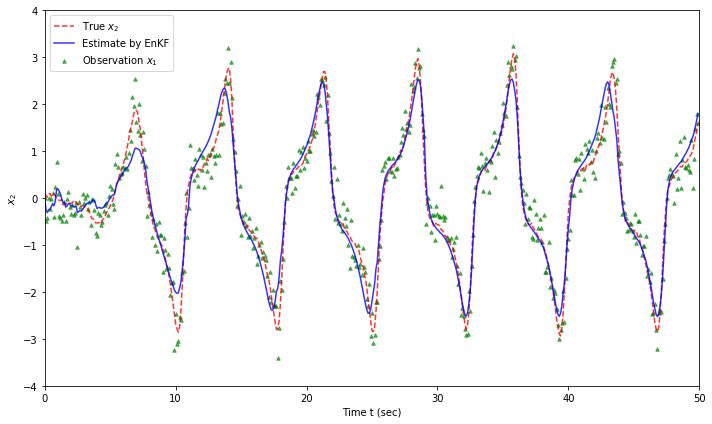

In [49]:
plt.figure(figsize=(10,6))
plt.scatter(time,y[:,0], label="Observation $x_1$", alpha=0.6, s=12, color="green", marker="^")
plt.plot(time,x[:,1], label="True $x_2$", color="red", linestyle="--",alpha=0.8)
plt.plot(time,xu[:,1], label="Estimate by EnKF", color="blue", alpha=0.8)
plt.xlim(0,dt*N)
plt.ylim(-4,4)
plt.ylabel("$x_2$")
plt.xlabel("Time t (sec)")
plt.tight_layout()
plt.legend()

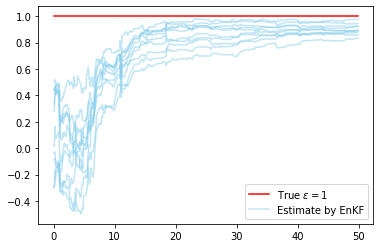

In [24]:
plt.plot(time,x[:,2], color="red", label="True $\epsilon=1$")
plt.plot(time, Xp[:,0,2], alpha=0.5, color="skyblue", label="Estimate by EnKF")
for i in range(1,10):
    plt.plot(time, Xp[:,i,2], alpha=0.5, color="skyblue")
plt.legend()